This script is used to produce Figure 3 (proportion of annual NPP produced during the bloom, and change in the rate of daily NPP during the bloom) and Figure S2 (emergence locations for total NPP, bloom NPP, and rate of bloom NPP) for the Payne et al. paper "End-of-century Arctic Ocean phytoplankton blooms start a month earlier due to anthropogenic climate change". 

1. Import Packages

In [1]:
import numpy as np
import numpy.ma as ma
import xarray as xr
import glob
import matplotlib.pyplot as plt
import matplotlib.path as mpath
import cmocean
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from scipy import stats
import math
import matplotlib.path as mpath
import matplotlib.ticker as mticker
import xesmf as xe

2. Read in a randomly chosen NPP file. This is used to generate latitude (lat) and longitude (lon) fields for CESM files.

In [2]:
vdir = 'ocn' # 'ocn' or 'ice'
vnam = 'photoC_diat_zint_2'#, 'photoC_diaz_zint', 'photoC_sp_zint']#,'photoC_diaz_zint','photoC_sp_zint'] # 'aice' # 'SST'
fdir = '/glade/campaign/cgd/cesm/CESM2-LE/'+ vdir + '/proc/tseries/day_1/' + vnam + '/'

fnam = 'b.e21.BSSP370cmip6.f09_g17.LE2-1301.003.pop.h.ecosys.nday1.photoC_diat_zint_2.20450102-20550101.nc'

ncfile = xr.open_dataset(fdir + fnam)
lon = ncfile.TLONG.values
lat = ncfile.TLAT.values

ok = ~np.isnan(lon)
xp = ok.ravel().nonzero()[0]
fp = lon[~np.isnan(lon)]
x  = np.isnan(lon).ravel().nonzero()[0]
lon[np.isnan(lon)] = np.interp(x, xp, fp)

ok = ~np.isnan(lat)
xp = ok.ravel().nonzero()[0]
fp = lat[~np.isnan(lat)]
x  = np.isnan(lat).ravel().nonzero()[0]
lat[np.isnan(lat)] = np.interp(x, xp, fp)

3. Make two arrays (areacello_ocn and arctic_ocn) that gives the area (in m2) of each grid cell in the larger region (latitude > 50°N) and in the Arctic Ocean (latitude > 66.5°N).

In [3]:
# b. Open up the areacello (area for ocean grid cells) file. I'll use this to calculate sea ice areal coverage
acdir = '/glade/collections/cmip/CMIP6/CMIP/NCAR/CESM2/historical/r1i1p1f1/Ofx/areacello/gn/files/d20190308/areacello_Ofx_CESM2_historical_r1i1p1f1_gn.nc'
acfil = xr.open_dataset(acdir)
areacello = acfil['areacello'].values # tarea <- ocean files
areacello_ocn = np.full([384,320], np.nan)
for i in np.arange(0,384):
    for j in np.arange(0,320):
        if np.isnan(ncfile['photoC_diat_zint_2'][180,i,j]) == False and ncfile["TLAT"][i,j] > 50:
            areacello_ocn[i,j] = areacello[i,j]


/glade/u/apps/opt/conda/envs/npl-2024a/lib/python3.11/site-packages/xarray/conventions.py:448: SerializationWarning: variable 'areacello' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


In [4]:
acdir = '/glade/collections/cmip/CMIP6/CMIP/NCAR/CESM2/historical/r1i1p1f1/Ofx/areacello/gn/files/d20190308/areacello_Ofx_CESM2_historical_r1i1p1f1_gn.nc'
acfil = xr.open_dataset(acdir)
areacello = acfil['areacello'].values # tarea <- ocean files
arctic_ocn = np.full([384,320], np.nan)
for i in np.arange(0,384):
    for j in np.arange(0,320):
        if np.isnan(ncfile['photoC_diat_zint_2'][180,i,j]) == False and ncfile["TLAT"][i,j] > 66.5:
            arctic_ocn[i,j] = areacello[i,j]


/glade/u/apps/opt/conda/envs/npl-2024a/lib/python3.11/site-packages/xarray/conventions.py:448: SerializationWarning: variable 'areacello' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


4. Read in bloom start (max_25) and end (max_25_2) files and npp during the bloom (npp_bloom) and total annual npp (npp_tot). These files were created for each year and across all ensemble members using the "BloomMetrics" script. Bloom start occurs on the date when biomass first surpasses 25% of the maximum biomass at any given grid cell, and end occurs on the date when biomass first diminishes below 25% of the maximum following the peak in biomass. I then set any zero values to 'nan'.

In [6]:
max_25 = np.zeros([14,384,320,50]); max_25_2 = np.zeros([14,384,320,50]); 
npp_tot = np.zeros([14,384,320,50]); npp_bloom = np.zeros([14,384,320,50]); 
for yrset in np.arange(0,14):
    yrnum = str(1970 + yrset*10)
    dir = np.loadtxt("/glade/u/home/cpayne/Projects/BloomLength/AnnualGC/" + yrnum + "_max_25.txt")
    max_25[yrset,:,:,:] = dir.reshape(384,320,50)
    dir = np.loadtxt("/glade/u/home/cpayne/Projects/BloomLength/AnnualGC/" + yrnum + "_max_25_2.txt")
    max_25_2[yrset,:,:,:] = dir.reshape(384,320,50)
    dir = np.loadtxt("/glade/u/home/cpayne/Projects/BloomLength/AnnualGC/" + yrnum + "_npp_bloom.txt")
    npp_bloom[yrset,:,:,:] = dir.reshape(384,320,50)
    dir = np.loadtxt("/glade/u/home/cpayne/Projects/BloomLength/AnnualGC/" + yrnum + "_npp_tot.txt")
    npp_tot[yrset,:,:,:] = dir.reshape(384,320,50)


In [7]:
npp_bloom = np.where(npp_bloom==0, np.nan, npp_bloom)
npp_tot = np.where(npp_tot==0, np.nan, npp_tot)
max_25 = np.where(max_25==0, np.nan, max_25)
max_25_2 = np.where(max_25_2==0, np.nan, max_25_2)

5. Here, I read in the sea ice mask and then I regrid the sea ice files to an even grid, which allows me to plot them as contours on the bloom importance maps below.

In [8]:
# a. Read in a shapefile of the sea ice masks (perennial ice, seasonal ice, open water)
ds_simask = xr.open_dataset('/glade/u/home/cpayne/Projects/BloomLength/Input/simask.nc')
si_clim = ds_simask["si_clim"]
si_ens = ds_simask["si_ens"]

# load the xarray lat/lon files from pop grid
TLONG = ncfile.TLONG
TLAT = ncfile.TLAT

# Rename TLON and TLAT coordinates to be lon and lat so we can join them with sea ice data
TLONG = TLONG.rename({'nlon':'lon','nlat':'lat'})
TLAT =  TLAT.rename({'nlon':'lon','nlat':'lat'})

# reset sea ice lat/lon coordinates since TLON looks weird (above)
si_clim['TLON'] = TLONG
si_clim['TLAT'] = TLAT

si_ens['TLON'] = TLONG
si_ens['TLAT'] = TLAT

#Now rename TLON and TLAT coordinates to be lon and lat because regridders needs that specific naming
si_clim = si_clim.rename({'TLON':'lon','TLAT':'lat'})
si_ens = si_ens.rename({'TLON':'lon','TLAT':'lat'})


In [9]:
si_clim

<xarray.DataArray 'si_clim' (year: 14, lat: 384, lon: 320)>
[1720320 values with dtype=float64]
Coordinates:
    lon      (lat, lon) float64 320.6 321.7 322.8 323.9 ... 318.9 319.4 319.8
    lat      (lat, lon) float64 -79.22 -79.22 -79.22 -79.22 ... 72.2 72.19 72.19
  * year     (year) int64 1970 1980 1990 2000 2010 ... 2060 2070 2080 2090 2100
    ULONG    (lat, lon) float64 ...
    ULAT     (lat, lon) float64 ...
    TLONG    (lat, lon) float64 320.6 321.7 322.8 323.9 ... 318.9 319.4 319.8

In [10]:
# Setting up a target grid 
# Do not include 90N and 90S otherwise cartopy gets rage-y (i.e. it doesn't work) when plotting
lat_new = np.arange(-89.5,90.0,0.5) 
lon_new = np.arange(0.0,361.0,1.0)

#create a meshgrid (2D fields of lats and lons)
lon2d,lat2d=np.meshgrid(lon_new,lat_new) 
#set up the target grid as an xarray Dataset
target_grid=xr.Dataset({'lat': (['y', 'x'], lat2d),'lon': (['y', 'x'], lon2d)})

#input grid, output grid, method, keyword arguments
regridder = xe.Regridder(si_clim, target_grid, 'nearest_s2d',periodic=True,reuse_weights=False)

# actually do the regridding
si_clim_regrid = regridder(si_clim)
si_ens_regrid = regridder(si_ens)

6. Here I plot Fig 3A-C, just altering the 'yr' variable

/glade/derecho/scratch/cpayne/tmp/ipykernel_130035/3214186394.py:17: RuntimeWarning: Mean of empty slice
  data_plt = np.round(np.nanmean(si_ens_regrid[:,yr,:,:],axis=0),0)


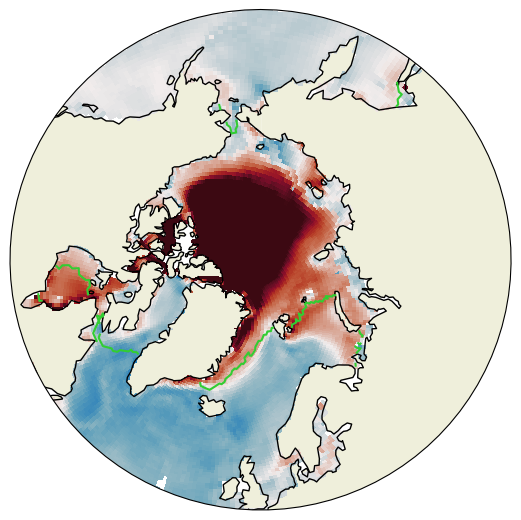

In [21]:
# make circular boundary for polar stereographic circular plots
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

# set figure basics (size, projection, and year of choice)
yr = 0
# fig = plt.figure(figsize = (6.5,6.5))
fig = plt.figure(figsize = (2.5,2.5))
# fig = plt.figure(figsize = (3,3))
ax = plt.axes(projection=ccrs.NorthPolarStereo()); 
ax.set_boundary(circle, transform=ax.transAxes)
ax.set_extent([-180, 180, 50, 90], crs = ccrs.PlateCarree());

# find the sea ice contours (data_plt) and the variable of interest (npp_bloom/npp_tot)
data_plt = np.round(np.nanmean(si_ens_regrid[:,yr,:,:],axis=0),0)
vari = np.mean(npp_bloom[yr,:,:,:]/npp_tot[yr,:,:,:], axis=2)

# plot changes in the actual variable of interest
pc = ax.pcolormesh(lon, lat, vari*100, 
                    transform=ccrs.PlateCarree(), vmin = 20, vmax = 90, cmap='cmo.thermal');

# add contours to show the yr sea ice zone contours
this1=ax.contour(lon2d,lat2d,data_plt, levels = np.arange(0,3,1),
                 colors=['limegreen','darkviolet'],linestyles='solid', linewidths=1.5,
                 transform=ccrs.PlateCarree())    

# add land on top and colorbar
ax.coastlines();  ax.add_feature(cfeature.LAND); #plt.colorbar(pc, orientation='horizontal', extend='both');
# plt.colorbar(pc, extend='both')

# print this figure
# figdir = '/glade/u/home/cpayne/Projects/BloomLength/PresentationFigs/2100NPPprop.png';
figdir = '/glade/u/home/cpayne/Projects/BloomLength/Figures/Fig3a.png';
# plt.savefig(figdir,facecolor='none', dpi = 600);
# plt.close()


7. Here I prepare variables to plot Figure 3D and E. I choose the data I want to plot across the Arctic by comparing changes in mean daily NPP during the bloom. I use 'yr2' to control the year I compare to 1970 (=0) and 'vari' and 'vari2' to control which variable I analyze. Bloom length = max_25_2 - max_25.

In [13]:
yr2 = 13 # 5 = 2020, 8 = 2050, 13 = 2100
vari = npp_bloom[0,:,:,:]/(max_25_2[0,:,:,:]-max_25[0,:,:,:])
vari2 = npp_bloom[yr2,:,:,:]/(max_25_2[yr2,:,:,:]-max_25[yr2,:,:,:])
varichange = np.full([384,320],np.nan)
for i in np.arange(0,384):
    for j in np.arange(0,320):
        if np.isnan(areacello_ocn[i,j]) == False:
            ttest = stats.ttest_rel(vari[i,j,:], vari2[i,j,:])
            if ttest.pvalue < 0.05:
                varichange[i,j] = (np.nanmean(vari2[i,j,:]) - np.nanmean(vari[i,j,:]))/np.nanmean(vari[i,j,:])*100
                

8. Here I plot Fig 3D and E after altering variables in the cell above.

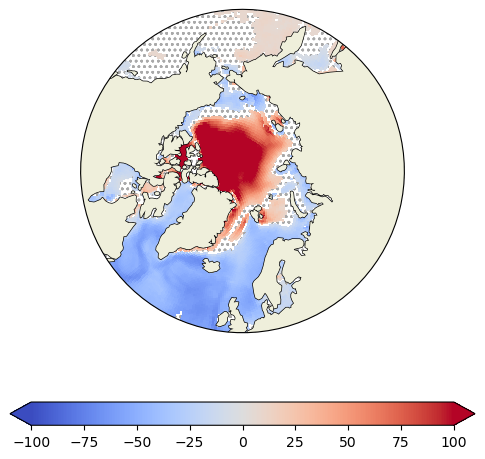

In [14]:
# make circular boundary for polar stereographic circular plots
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

# set figure basics (size, projection)
# fig = plt.figure(figsize = (2.5,2.5))
fig = plt.figure(figsize = (6,6))
ax = plt.axes(projection=ccrs.NorthPolarStereo()); 
ax.set_boundary(circle, transform=ax.transAxes)
ax.set_extent([-180, 180, 50, 90], crs = ccrs.PlateCarree());

# make the background stippled throughout the region
plt.rcParams['hatch.color'] = 'darkgray'
ax.contourf(lon, lat, areacello,
            transform=ccrs.PlateCarree(),
            colors='none',
            # levels = [.9,1.1],
            zorder = 0,
            hatches=['...'])

# plot changes in the actual variable of interest on top
pc = ax.pcolormesh(lon, lat,varichange, 
                    transform=ccrs.PlateCarree(), vmin = -100, vmax = 100, cmap='coolwarm',zorder=1);

# add land on top and colorbar
ax.coastlines();  ax.add_feature(cfeature.LAND,zorder=2); plt.colorbar(pc, orientation='horizontal', extend='both');

# print this figure
# figdir = '/glade/u/home/cpayne/CESM2LE/PresentationFigs/2100NPPprop.png';
# figdir = '/glade/u/home/cpayne/Projects/BloomLength/Figures/Fig3dcbar.png';
# plt.savefig(figdir,facecolor='none', dpi = 600);
# plt.close()

9. Here, I choose the data I want to assess whether it has emerged into a new climate state. I use 'yr2' to control the year I compare to 1970 (=0) and 'vari' and 'vari2' to control which variable I analyze. The yr2 data is considered to have emerged if it is outside of mean(yr1) +/- 2*St.Dev.

In [52]:
yr2 = 13 # 5 = 2020, 8 = 2050, 13 = 2100
data_plt = np.round(np.nanmean(si_ens_regrid[:,0,:,:],axis=0),0)
data_plt2 = np.round(np.nanmean(si_ens_regrid[:,yr2,:,:],axis=0),0)
vari = npp_tot[0,:,:,:]#/(max_25_2[0,:,:,:]-max_25[0,:,:,:])
vari2 = npp_tot[yr2,:,:,:]#/(max_25_2[yr2,:,:,:]-max_25[yr2,:,:,:])
emergence = np.full([384,320],np.nan); highrange = np.full([384,320],np.nan); lowrange = np.full([384,320],np.nan)
for i in np.arange(0,384):
    for j in np.arange(0,320):
        if np.isnan(areacello_ocn[i,j]) == False:
            highrange[i,j] = np.nanmean(vari[i,j,:]) + (2*np.nanstd(vari[i,j,:]))
            lowrange[i,j] = np.nanmean(vari[i,j,:]) - (2*np.nanstd(vari[i,j,:]))
            if np.nanmean(vari2[i,j,:]) > highrange[i,j] or np.nanmean(vari2[i,j,:]) < lowrange[i,j]:
                emergence[i,j] = 1

/glade/derecho/scratch/cpayne/tmp/ipykernel_53124/3509805679.py:2: RuntimeWarning: Mean of empty slice
  data_plt = np.round(np.nanmean(si_ens_regrid[:,0,:,:],axis=0),0)
/glade/derecho/scratch/cpayne/tmp/ipykernel_53124/3509805679.py:3: RuntimeWarning: Mean of empty slice
  data_plt2 = np.round(np.nanmean(si_ens_regrid[:,yr2,:,:],axis=0),0)


In [53]:
# Print the proportion of the Arctic and the larger region that has emerged by y2
print(np.nansum(emergence * arctic_ocn)/np.nansum(arctic_ocn),np.nansum(emergence * areacello_ocn)/np.nansum(areacello_ocn))


0.5344223887005404 0.4971836630611007


Here, I plot the grid cell points that have emerged by y2 (Figure S2A-F).

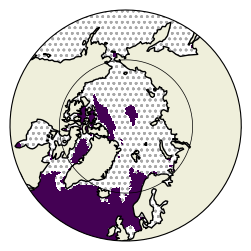

In [41]:
# make circular boundary for polar stereographic circular plots
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

fig = plt.figure(figsize=(3,3)) 
ax = plt.axes(projection=ccrs.NorthPolarStereo()); 
ax.set_boundary(circle, transform=ax.transAxes)
ax.set_extent([-180, 180, 50, 90], crs = ccrs.PlateCarree());
gl = ax.gridlines(crs=ccrs.PlateCarree(), linewidth=.5, color='black')
gl.ylocator = mticker.FixedLocator([66.5])
gl.xlocator = mticker.FixedLocator([])
plt.rcParams['hatch.color'] = 'darkgray'
ax.contourf(lon, lat, areacello,
            transform=ccrs.PlateCarree(),
            colors='none',
            # levels = [.9,1.1],
            zorder = 0,
            hatches=['...'])
pc = ax.pcolormesh(lon, lat, emergence, 
                   transform=ccrs.PlateCarree(), zorder = 1); 
ax.coastlines();  ax.add_feature(cfeature.LAND, zorder = 1); 
figdir = '/glade/u/home/cpayne/Projects/BloomLength/Figures/FigS2f.png';
plt.savefig(figdir,facecolor='none', dpi = 600);


In [65]:
yr2 = 13 # 5 = 2020, 8 = 2050, 13 = 2100
vari = npp_bloom[0,:,:,:]/npp_tot[0,:,:,:]#/(max_25_2[0,:,:,:]-max_25[0,:,:,:])
vari2 = npp_bloom[yr2,:,:,:]/npp_tot[yr2,:,:,:]#/(max_25_2[yr2,:,:,:]-max_25[yr2,:,:,:])
varichange = np.full([384,320],np.nan)
for i in np.arange(0,384):
    for j in np.arange(0,320):
        if np.isnan(areacello_ocn[i,j]) == False:
            ttest = stats.ttest_rel(vari[i,j,:], vari2[i,j,:])
            if ttest.pvalue < 0.05:
                varichange[i,j] = (np.nanmean(vari2[i,j,:]) - np.nanmean(vari[i,j,:]))*100#/np.nanmean(vari[i,j,:])*100


/glade/derecho/scratch/cpayne/tmp/ipykernel_29274/4039393330.py:12: RuntimeWarning: Mean of empty slice
  data_plt = np.round(np.nanmean(si_ens_regrid[:,yr,:,:],axis=0),0)


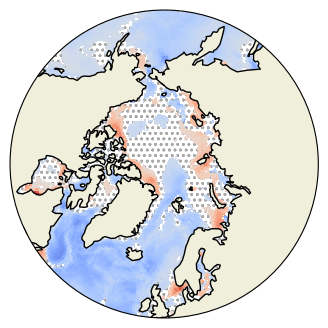

In [66]:
# make circular boundary for polar stereographic circular plots
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

# fig = plt.figure(figsize = (6.5,6.5))
# fig = plt.figure(figsize = (2.5,2.5))
# fig = plt.figure(figsize = (3,3))
fig = plt.figure(figsize = (4,4))
# yr = 13
data_plt = np.round(np.nanmean(si_ens_regrid[:,yr,:,:],axis=0),0)
vari = np.mean(npp_bloom[0,:,:,:]/npp_tot[0,:,:,:], axis=2)
vari2 = np.mean(npp_bloom[yr,:,:,:]/npp_tot[yr,:,:,:], axis=2)
ax = plt.axes(projection=ccrs.NorthPolarStereo()); 
ax.set_boundary(circle, transform=ax.transAxes)
ax.set_extent([-180, 180, 50, 90], crs = ccrs.PlateCarree());
ax.contourf(lon, lat, areacello,
            transform=ccrs.PlateCarree(),
            colors='none',
            # levels = [.9,1.1],
            zorder = 0,
            hatches=['...'])
pc = ax.pcolormesh(lon, lat, varichange, zorder = 1,
                    transform=ccrs.PlateCarree(), vmin = -50, vmax = 50, cmap='coolwarm');
# this1=ax.contour(lon2d,lat2d,data_plt, levels = np.arange(0,3,1),
#                  colors=['limegreen','darkviolet'],linestyles='solid', linewidths=1.5,
#                  transform=ccrs.PlateCarree())    
ax.coastlines();  ax.add_feature(cfeature.LAND, zorder = 1); #plt.colorbar(pc, orientation='horizontal', extend='both');
# plt.colorbar(pc, extend='both')
# figdir = '/glade/u/home/cpayne/CESM2LE/PresentationFigs/2100NPPprop.png';
# figdir = '/glade/u/home/cpayne/Projects/BloomLength/Figures/Fig3acbar.png';
# plt.savefig(figdir,facecolor='none', dpi = 600);
# plt.close()

In [8]:
si1970 = np.full([384,320],np.nan); siyr = np.full([384,320],np.nan); 
sichange = np.full([384,320],np.nan)
yr1 = 13 #5 = 2020, 8 = 2050, 13 = 2100
for i in np.arange(0,384):
    for j in np.arange(0,320):
        if np.isnan(areacello_ocn[i,j]) == False:
            si1970[i,j] = np.round(np.nanmean(si_ens[:,0,i,j]),0)
            siyr[i,j] = np.round(np.nanmean(si_ens[:,yr1,i,j]),0)
            if si1970[i,j] == 0:
                if siyr[i,j] == 0:
                    sichange[i,j] = 0 #Ice free -> ice free
                if siyr[i,j] == 1:
                    sichange[i,j] = 1 #Ice free -> seasonal
                if siyr[i,j] == 2:
                    sichange[i,j] = 2 #Ice free -> perennial
            if si1970[i,j] == 1:
                if siyr[i,j] == 0:
                    sichange[i,j] = 3 #Seasonal -> ice free
                if siyr[i,j] == 1:
                    sichange[i,j] = 4 #Seasonal -> seasonal
                if siyr[i,j] == 2:
                    sichange[i,j] = 5 #Seasonal -> perennial
            if si1970[i,j] == 2:
                if siyr[i,j] == 0:
                    sichange[i,j] = 6 #Perennial -> ice free
                if siyr[i,j] == 1:
                    sichange[i,j] = 7 #Perennial -> seasonal
                if siyr[i,j] == 2:
                    sichange[i,j] = 8 #Perennial -> perennial

In [9]:
si_zone = np.full([384,320],np.nan)
for i in np.arange(0,384):
    for j in np.arange(0,320):
        if sichange[i,j] == 6 or sichange[i,j] == 7 or sichange[i,j] == 8:# or sichange[i,j] == 5 or sichange[i,j] == 7 or sichange[i,j] == 8:
            si_zone[i,j] = areacello_ocn[i,j]
            

In [15]:
import numpy.ma as ma
npp_simean = np.zeros([50]); npp_simean2 = np.zeros([50])
yr = 5
for ens in np.arange(0,50):
    npp_simean[ens] = np.nansum((npp_bloom[0,:,:,ens]/(max_25_2[0,:,:,ens] - (max_25[0,:,:,ens]))) * si_zone)/np.nansum(si_zone)
    npp_simean2[ens] = np.nansum((npp_bloom[yr,:,:,ens]/(max_25_2[yr,:,:,ens] - (max_25[yr,:,:,ens]))) * si_zone)/np.nansum(si_zone)


In [67]:
import numpy.ma as ma
npp_simean = np.zeros([50]); npp_simean2 = np.zeros([50]);npp_simean3 = np.zeros([50])
yr = 5
yr2 = 13
for ens in np.arange(0,50):
    npp_simean[ens] = np.nansum((npp_bloom[0,:,:,ens]/(npp_tot[0,:,:,ens])) * arctic_ocn)/np.nansum(arctic_ocn)
    npp_simean2[ens] = np.nansum((npp_bloom[yr,:,:,ens]/(npp_tot[yr,:,:,ens])) * arctic_ocn)/np.nansum(arctic_ocn)
    npp_simean3[ens] = np.nansum((npp_bloom[yr2,:,:,ens]/(npp_tot[yr2,:,:,ens])) * arctic_ocn)/np.nansum(arctic_ocn)


In [69]:
import numpy.ma as ma
npp_simean = np.zeros([50]); npp_simean2 = np.zeros([50]);npp_simean3 = np.zeros([50])
yr = 5
yr2 = 13
for ens in np.arange(0,50):
    npp_simean[ens] = np.nansum((npp_bloom[0,:,:,ens]/(npp_tot[0,:,:,ens])) * areacello_ocn)/np.nansum(areacello_ocn)
    npp_simean2[ens] = np.nansum((npp_bloom[yr,:,:,ens]/(npp_tot[yr,:,:,ens])) * areacello_ocn)/np.nansum(areacello_ocn)
    npp_simean3[ens] = np.nansum((npp_bloom[yr2,:,:,ens]/(npp_tot[yr2,:,:,ens])) * areacello_ocn)/np.nansum(areacello_ocn)


In [70]:
print(np.mean(npp_simean),np.mean(npp_simean2),np.mean(npp_simean3))

0.6356738830780624 0.6134685714445675 0.5724143559602352


In [46]:
print(np.mean(npp_simean),np.mean(npp_simean2),np.mean(npp_simean)-np.mean(npp_simean2),np.std(npp_simean))

0.5364939533376777 0.5118901476791072 0.024603805658570455 0.02233699178007837


In [17]:
.234/.152


1.5394736842105265

In [57]:
np.nan(np.mean(npp_bloom[0,:,:,:]/npp_bloom[0,:,:,:],axis = 2)*areacello_ocn)

TypeError: 'float' object is not callable

In [11]:
# a. Read in array describing what region each grid cell corresponds to. Shelfmask numbers correspond to:
# 1: the shelf (<1000m) of the sub-Arctic (50-66.5°N)
# 2: the shelf (<1000m) of the Arctic (> 66.5°N)
# 3: the basin (>1000m) of the sub-Arctic (50-66.5°N)
# 4: the basin (>1000m) of the Arctic (> 66.5°N)

dir = np.loadtxt("/glade/u/home/cpayne/Projects/PredictPerfect/Input/shelfmask.txt")
shelfmask = dir.reshape(384,320)

In [28]:
lim_1970_shel = np.zeros([4,50]);lim_2020_shel = np.zeros([4,50]);lim_2100_shel = np.zeros([4,50])
for shel in np.arange(0,4):
    shelarea = 0
    for i in np.arange(0,384):
        for j in np.arange(0,320):
            if shelfmask[i,j] == shel + 1 and np.isnan(areacello_ocn[i,j]) == False and np.isnan(npp_bloom[0,i,j,0]) == False:
                lim_1970_shel[shel,:] = npp_bloom[0,i,j,:] /npp_tot[0,i,j,:] *areacello_ocn[i,j] + lim_1970_shel[shel,:]
                lim_2020_shel[shel,:] = npp_bloom[5,i,j,:] /npp_tot[5,i,j,:] *areacello_ocn[i,j] + lim_2020_shel[shel,:]
                lim_2100_shel[shel,:] = npp_bloom[13,i,j,:]/npp_tot[13,i,j,:]*areacello_ocn[i,j] + lim_2100_shel[shel,:]
                shelarea = shelarea + areacello_ocn[i,j]
    lim_1970_shel[shel,:] = lim_1970_shel[shel,:]/shelarea
    lim_2020_shel[shel,:] = lim_2020_shel[shel,:]/shelarea
    lim_2100_shel[shel,:] = lim_2100_shel[shel,:]/shelarea


In [40]:
# 1: the shelf (<1000m) of the sub-Arctic (50-66.5°N)
# 2: the shelf (<1000m) of the Arctic (> 66.5°N)
# 3: the basin (>1000m) of the sub-Arctic (50-66.5°N)
# 4: the basin (>1000m) of the Arctic (> 66.5°N)
shel = 2
print(np.nanmean(lim_1970_shel[shel,:]))
print(np.nanmean(lim_2020_shel[shel,:]))
print(np.nanmean(lim_2100_shel[shel,:]))

0.5412493919440691
0.5106871575198247
0.4018221958964594


In [26]:
lim_1970_shel[1,:]

array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan])